# MCMC Fitting the absorption profile to an absorption line  

This example conducts HMC-NUTS fitting to a mock absorption line. We use the absorption model based on Tepper 
approximation of Voigt profile, lpf.FAbsVRewofz in exojax.lpf (line profile functions) module. 

HMC-NUTS: Hamiltonian Monte Carlo No-U-Turn Sample using numpyro

In [3]:
%load_ext autoreload
%autoreload 2

# importing lpf modile in exojax.spec
from exojax.spec import lpf
from exojax.spec import absorption

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map

import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

plt.style.use('bmh')
#numpyro.set_platform("cpu")
#numpyro.set_platform("gpu")

In [5]:
# generating mock absorption data
np.random.seed(34)
N=20
nuarr=jnp.linspace(-10,10,N)
sigin=0.01
sDfix = jnp.array(1.0)
gLfix = jnp.array(0.5)
Afix = jnp.array(1.0)
nu0fix = 0.7
data=lpf.FAbsVRewofzx(nuarr-nu0fix,sDfix,gLfix,Afix)+np.random.normal(0,sigin,size=N)

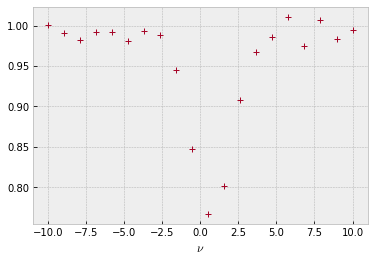

In [6]:
# Here is a mock dataset
plt.plot(nuarr,data,"+",color="C1")
plt.xlabel("$\\nu$")
plt.show()

In [7]:
#probabilistic model using numpyro
def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    mu = lpf.FAbsVRewofzx(nu-nu0,sD,gL,A)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [8]:
# OK, a HMC-NUTS!
# Our model, lpf.FAbsVRewofz, is compatible to jax. Autograd works. We can perform a HMC-NUTS.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

  0%|          | 0/3000 [00:00<?, ?it/s]


AssertionError: length mismatch: [1, 5]

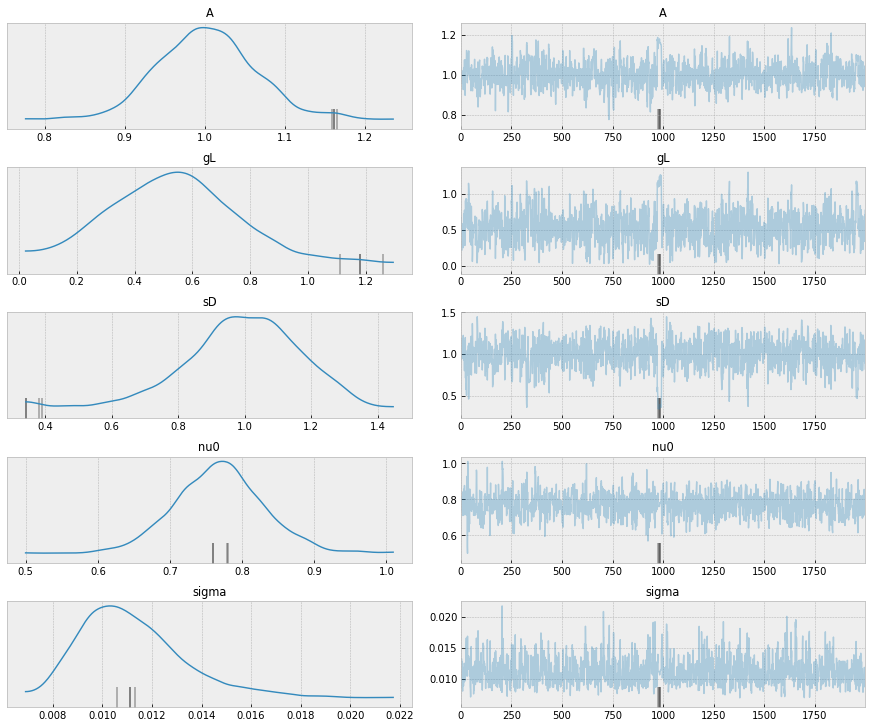

In [21]:
#arviz is superuseful to check chains
arviz.plot_trace(mcmc, var_names=["A", "gL", "sD","nu0","sigma"])
plt.show()

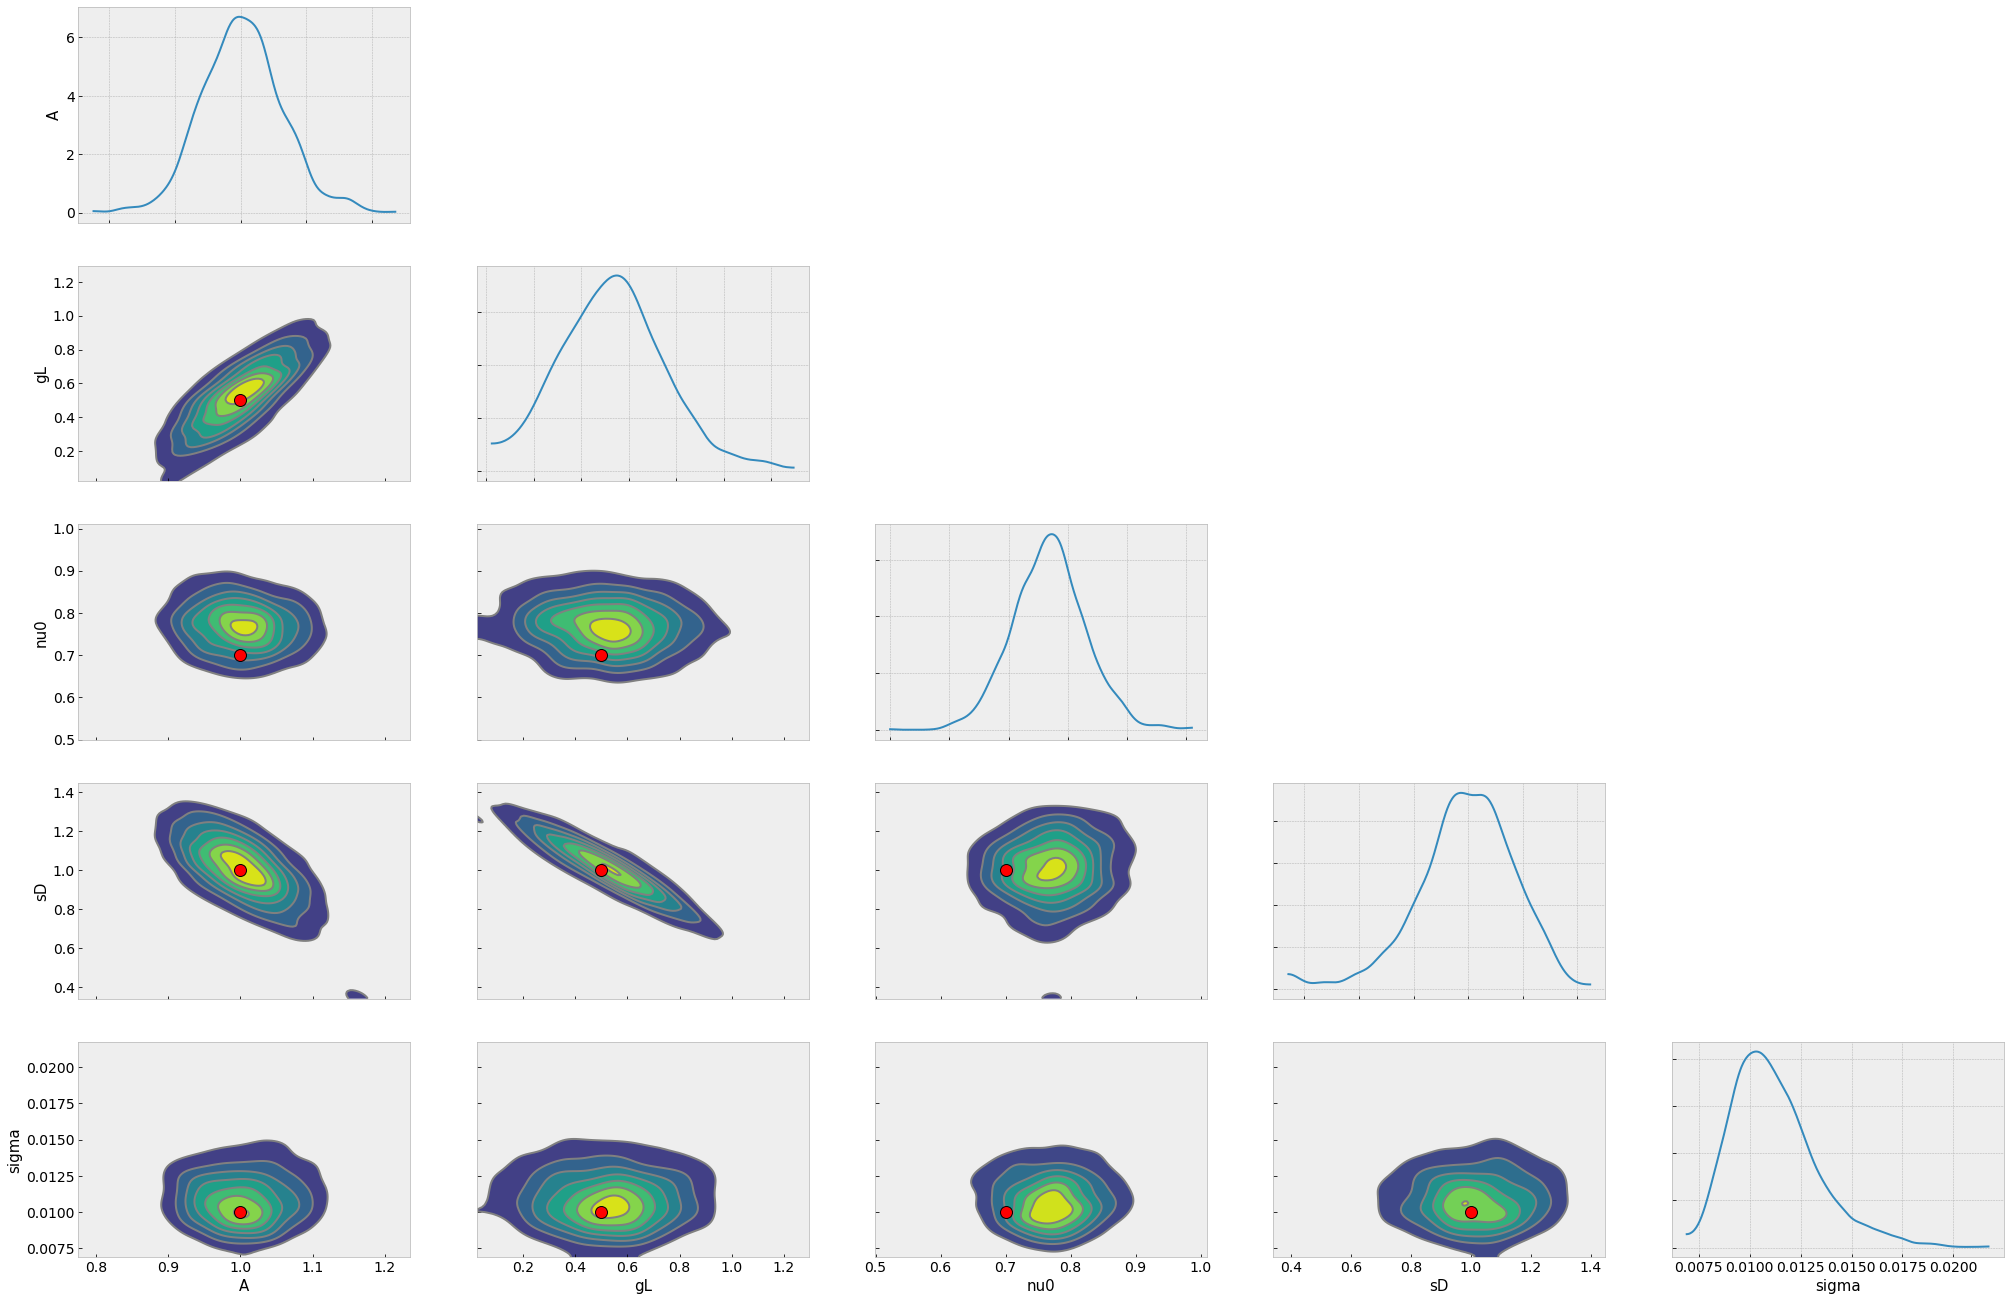

In [11]:
#cool and flexible corner plot in arviz. You can also try kind='hexbin' instead of 'kde' for instance.
#arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=True)
refs={}
refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

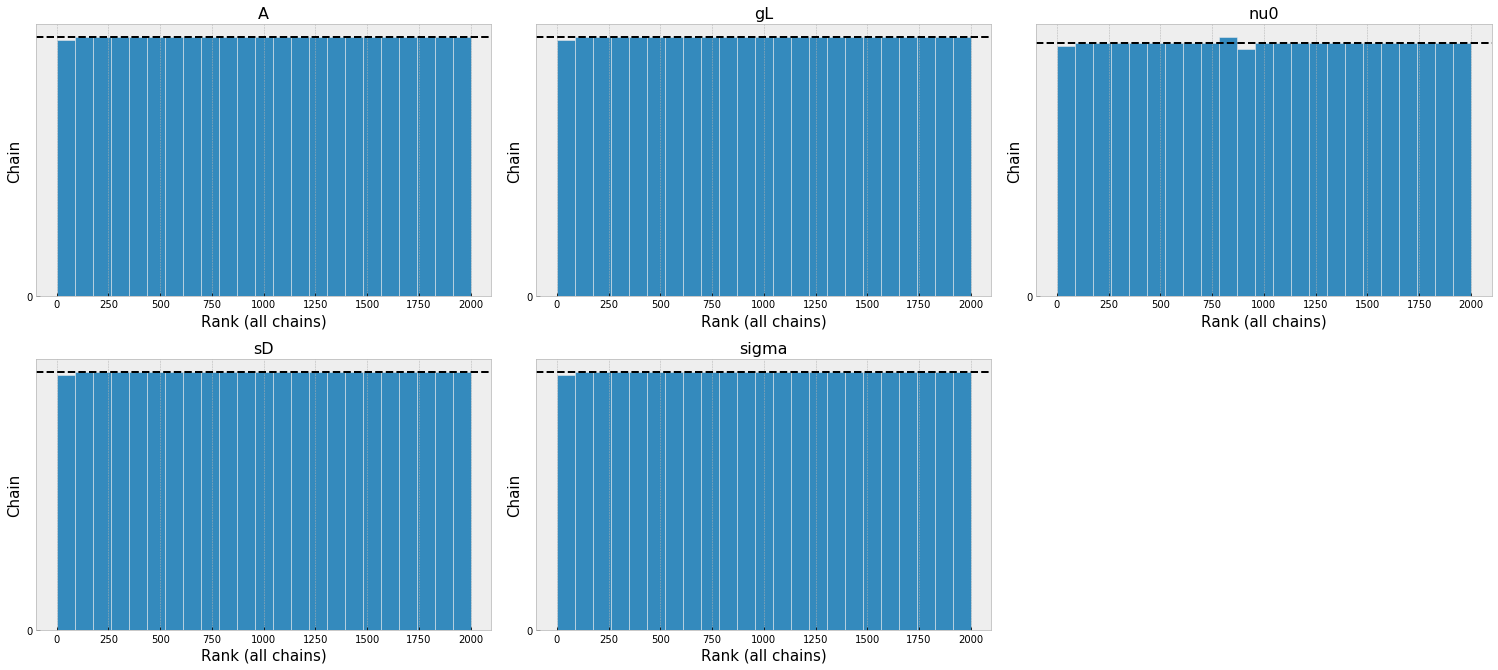

In [12]:
# further check of chain
arviz.plot_rank(arviz.from_numpyro(mcmc))
plt.show()

In [13]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = jnp.linspace(-12,12,100)
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

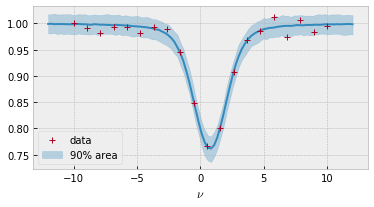

In [14]:
# final plot of median and 90% credible area of the prediction

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_absorption.png")
plt.show()

In [23]:
#when using numatrix
np.random.seed(38)
N=1000
nur=1000
nuarr=jnp.linspace(-nur,nur,N)
sigin=0.01
sDfix = jnp.array(1.0)
gLfix = jnp.array(0.5)

Nmol=100
hatnufix = (np.random.rand(Nmol)-0.5)*nur*2
Sfix=np.random.rand(Nmol)
Afix=jnp.array(0.03)
nu0fix = 0.7
#f = lambda nu: lpf.MultiAbsVTc(nu-nu0fix,sDfix,gLfix,Afix,Sfix,hatnufix)

numatrix=lpf.make_numatrix(nuarr,hatnufix,nu0fix)

(lpf.VoigtRewofz(numatrix.flatten(),sDfix,gLfix)).reshape(np.shape(numatrix))

DeviceArray([[2.68264358e-07, 2.69664326e-07, 2.71075294e-07, ...,
              1.05929580e-07, 1.05584398e-07, 1.05240908e-07],
             [5.37904512e-08, 5.39158727e-08, 5.40417453e-08, ...,
              2.09119503e-06, 2.06116965e-06, 2.03178774e-06],
             [4.45975346e-08, 4.46922073e-08, 4.47871926e-08, ...,
              1.39314507e-05, 1.34237907e-05, 1.29434093e-05],
             ...,
             [6.38269171e-07, 6.43417820e-07, 6.48629566e-07, ...,
              7.10535915e-08, 7.08638836e-08, 7.06749290e-08],
             [1.82488554e-06, 1.84988153e-06, 1.87539626e-06, ...,
              5.50274670e-08, 5.48981376e-08, 5.47692665e-08],
             [2.39021318e-07, 2.40198489e-07, 2.41384413e-07, ...,
              1.14304484e-07, 1.13917601e-07, 1.13532700e-07]],            dtype=float32)